# Plotting Rainfall Rates using NEXRAD Data and PyART

### This code features manual radar file downloads. It works, it just takes a while to create all necessary images.

In [2]:
from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from glob import glob
import wradlib as wrl
import xarray as xr
import seaborn as sns


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/amedendorp/.conda/envs/clouds_env/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/amedendorp/.conda/envs/clouds_env/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [3]:
#Pulling the single file
RADAR_FILE= pyart.io.read('KLOT20130418_000354_V06')
print(RADAR_FILE)
radar = RADAR_FILE
title= '2013_04_18_KLOT_00:03:54Z_Rainfall_Rates'

In [3]:
# Estimate rainfall rate from reflectivity using a power law:
ah = pyart.retrieve.est_rain_rate_z(radar, alpha=0.0376, beta=0.6112, refl_field=None, rr_field=None)


In [4]:
# Adding 'rain_rate' field
radar.add_field('rain_rate', ah, replace_existing=True)


/home/amedendorp/.conda/envs/clouds_env/lib/python3.6/site-packages/pyart/map/gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


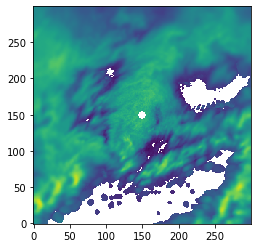

In [5]:
# Gridding the data:
# Mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields['reflectivity']['data'][:, -10:] = np.ma.masked

# Exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

# Perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (radar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 300, 300),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['reflectivity', 'rain_rate'])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
plt.show()

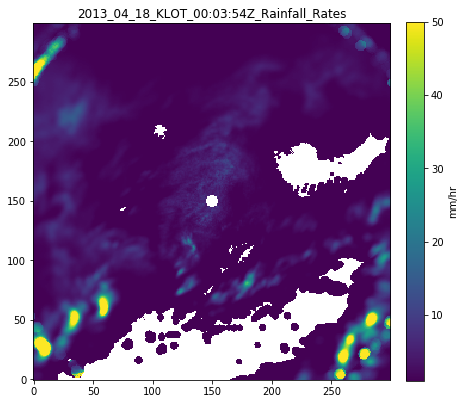

In [6]:
#Creating the rainfall rate plot from the gridded data:

fig = plt.figure(figsize=(7,7))
display = pyart.graph.RadarDisplay(radar)
ax = fig.add_subplot(111)
im = ax.imshow(grid.fields['rain_rate']['data'][0], origin='lower', vmin=1, vmax=50)
#cmap=cm.cividis

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='mm/hr')
plt.title(title)
plt.savefig('/home/amedendorp/Desktop/SAVUER/Rainfall_Rates/' + title, 
            bbox_inches='tight')
plt.show()